In [ ]:
!pip install git+https://github.com/keras-team/keras-tuner.git
!pip install autokeras

  Cloning https://github.com/keras-team/keras-tuner.git to /tmp/pip-req-build-ybokd1at
  Running command git clone -q https://github.com/keras-team/keras-tuner.git /tmp/pip-req-build-ybokd1at
  Created wheel for keras-tuner: filename=keras_tuner-1.0.4-py3-none-any.whl size=99129 sha256=f41b726db4c97968bdbb9acaa5a139fb72a17c5af1834d65c42504409dc1b0d7
  Stored in directory: /tmp/pip-ephem-wheel-cache-ea3d0bgm/wheels/e1/66/9f/f6c4d78f995ffaab8f76f55725a28cdcaa9b25910f7ac0326a
Successfully built keras-tuner
     |████████████████████████████████| 166 kB 8.9 MB/s 
     |████████████████████████████████| 454.3 MB 16 kB/s 
     |████████████████████████████████| 4.0 MB 51.8 MB/s 
     |████████████████████████████████| 1.2 MB 59.7 MB/s 
     |████████████████████████████████| 462 kB 76.7 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.39.0
    Uninstalling grpcio-1.39.0:
      Successfully uninstalled grpcio-1.39.0
  Attempting uninstall: tensorflow-estimator
  

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd '/gdrive/MyDrive/Colab Notebooks/WRI-Hackathon/python_scripts/training/KRS'

Mounted at /gdrive
/gdrive/MyDrive/Colab Notebooks/WRI-Hackathon/python_scripts/training/KRS


### Import libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import plot_partial_dependence, permutation_importance
from autokeras import StructuredDataRegressor
import matplotlib.pyplot as plt
import sys
import datetime
from datetime import date, timedelta
from tqdm.notebook import tqdm
# sys.path.insert(0, '../models')
# from krs_inflow_model import SimpleMLP

### Read Datasets

In [ ]:
inflow_df = pd.read_csv('../../dataset/reservoir_dataset_engg.csv')
inflow_df = inflow_df[inflow_df['RESERVOIR'] == 'K.R.S']
print(inflow_df.shape)
inflow_df.head()

(3274, 10)


,RESERVOIR,PRESENT_STORAGE_TMC,RES_LEVEL_FT,INFLOW_CUSECS,OUTFLOW_CUECS,YEAR,MONTH,DATE,DAY,SEASON
0,K.R.S,46.42,122.59,2029.0,2000.0,2011,1,1,0,WINTER
1,K.R.S,46.54,122.68,3084.0,1490.0,2011,1,2,1,WINTER
2,K.R.S,46.64,122.75,2776.0,1491.0,2011,1,3,2,WINTER
3,K.R.S,46.69,122.79,2311.0,1491.0,2011,1,4,3,WINTER
4,K.R.S,46.70,122.80,1847.0,1491.0,2011,1,5,4,WINTER


In [ ]:
weather_df = pd.read_csv('../../dataset/Weather/mysuru_kodagu_hassan_weather.csv')
print(weather_df.shape)
weather_df.head()

(12783, 35)


,date,city_name,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain,clouds_all,broken clouds,overcast clouds,scattered clouds,sky is clear,few clouds,fog,light rain,mist,haze,moderate rain,heavy intensity rain,light intensity drizzle,drizzle,heavy intensity drizzle,very heavy rain,thunderstorm with heavy rain,thunderstorm with rain,thunderstorm,proximity shower rain,thunderstorm with light rain,shower rain,light intensity shower rain,light thunderstorm
0,2010-01-01,Hassan,21.77,22.02,17.22,26.35,1013.50,77.92,2.81,89.33,0.00,67.62,5,12,4,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2010-01-01,Kodagu,23.90,24.71,20.06,31.39,1012.17,83.50,1.55,104.21,0.94,51.92,3,4,8,0,6,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2010-01-01,Mysuru,24.18,24.51,18.82,30.30,1012.92,68.42,2.62,90.38,0.00,31.58,5,0,8,4,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2010-01-02,Hassan,20.73,20.80,14.47,27.35,1015.25,73.75,2.42,70.29,0.00,11.79,2,0,3,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2010-01-02,Kodagu,23.56,24.41,19.18,31.88,1014.08,78.38,1.41,112.46,0.00,22.75,3,0,3,13,3,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
weather_df['YYYY'] = weather_df['date'].str[:4].astype(int)
weather_df['MM'] = weather_df['date'].str[5:7].astype(int)
weather_df['DD'] = weather_df['date'].str[8:].astype(int)
weather_df

,date,city_name,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain,clouds_all,broken clouds,overcast clouds,scattered clouds,sky is clear,few clouds,fog,light rain,mist,haze,moderate rain,heavy intensity rain,light intensity drizzle,drizzle,heavy intensity drizzle,very heavy rain,thunderstorm with heavy rain,thunderstorm with rain,thunderstorm,proximity shower rain,thunderstorm with light rain,shower rain,light intensity shower rain,light thunderstorm,YYYY,MM,DD
0,2010-01-01,Hassan,21.77,22.02,17.22,26.35,1013.50,77.92,2.81,89.33,0.00,67.62,5,12,4,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2010,1,1
1,2010-01-01,Kodagu,23.90,24.71,20.06,31.39,1012.17,83.50,1.55,104.21,0.94,51.92,3,4,8,0,6,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2010,1,1
2,2010-01-01,Mysuru,24.18,24.51,18.82,30.30,1012.92,68.42,2.62,90.38,0.00,31.58,5,0,8,4,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2010,1,1
3,2010-01-02,Hassan,20.73,20.80,14.47,27.35,1015.25,73.75,2.42,70.29,0.00,11.79,2,0,3,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2010,1,2
4,2010-01-02,Kodagu,23.56,24.41,19.18,31.88,1014.08,78.38,1.41,112.46,0.00,22.75,3,0,3,13,3,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2010,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12778,2021-08-30,Kodagu,20.07,20.57,19.03,23.77,1009.00,93.50,1.71,241.83,0.00,49.00,0,12,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2021,8,30
12779,2021-08-30,Mysuru,22.36,22.90,19.59,28.21,1009.33,82.33,5.38,253.62,0.00,51.67,8,4,7,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2021,8,30
12780,2021-08-31,Hassan,21.86,22.21,18.87,26.31,1009.29,82.17,3.39,249.33,2.07,47.50,3,6,0,12,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2021,8,31
12781,2021-08-31,Kodagu,21.29,21.81,19.03,26.23,1009.79,89.21,1.78,245.88,4.14,49.62,0,9,0,12,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,2021,8,31


In [ ]:
kodagu_df = weather_df[weather_df['city_name'] == 'Kodagu'].reset_index(drop=True)
hassan_df = weather_df[weather_df['city_name'] == 'Hassan'].reset_index(drop=True)
mysuru_df = weather_df[weather_df['city_name'] == 'Mysuru'].reset_index(drop=True)

print(kodagu_df.shape, hassan_df.shape, mysuru_df.shape)

(4261, 38) (4261, 38) (4261, 38)


### Check Coorelation

In [ ]:
m = mysuru_df.copy()
m = m.merge(inflow_df, how='outer', left_on=['YYYY', 'MM', 'DD'], right_on=['YEAR', 'MONTH', 'DATE'])
assert m.shape[0] == 4261
m.head(2)

,date,city_name,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain,clouds_all,broken clouds,overcast clouds,scattered clouds,sky is clear,few clouds,fog,light rain,mist,haze,moderate rain,heavy intensity rain,light intensity drizzle,drizzle,heavy intensity drizzle,very heavy rain,thunderstorm with heavy rain,thunderstorm with rain,thunderstorm,proximity shower rain,thunderstorm with light rain,shower rain,light intensity shower rain,light thunderstorm,YYYY,MM,DD,RESERVOIR,PRESENT_STORAGE_TMC,RES_LEVEL_FT,INFLOW_CUSECS,OUTFLOW_CUECS,YEAR,MONTH,DATE,DAY,SEASON
0,2010-01-01,Mysuru,24.18,24.51,18.82,30.30,1012.92,68.42,2.62,90.38,0.0,31.58,5,0,8,4,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2010,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-02,Mysuru,23.21,23.24,16.74,29.32,1014.58,64.33,2.19,71.42,0.0,18.67,2,0,5,12,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2010,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
h = hassan_df.copy()
h = h.merge(inflow_df, how='outer', left_on=['YYYY', 'MM', 'DD'], right_on=['YEAR', 'MONTH', 'DATE'])
assert h.shape[0] == 4261
h.head(2)

,date,city_name,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain,clouds_all,broken clouds,overcast clouds,scattered clouds,sky is clear,few clouds,fog,light rain,mist,haze,moderate rain,heavy intensity rain,light intensity drizzle,drizzle,heavy intensity drizzle,very heavy rain,thunderstorm with heavy rain,thunderstorm with rain,thunderstorm,proximity shower rain,thunderstorm with light rain,shower rain,light intensity shower rain,light thunderstorm,YYYY,MM,DD,RESERVOIR,PRESENT_STORAGE_TMC,RES_LEVEL_FT,INFLOW_CUSECS,OUTFLOW_CUECS,YEAR,MONTH,DATE,DAY,SEASON
0,2010-01-01,Hassan,21.77,22.02,17.22,26.35,1013.50,77.92,2.81,89.33,0.0,67.62,5,12,4,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2010,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-02,Hassan,20.73,20.80,14.47,27.35,1015.25,73.75,2.42,70.29,0.0,11.79,2,0,3,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2010,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
k = kodagu_df.copy()
k = k.merge(inflow_df, how='outer', left_on=['YYYY', 'MM', 'DD'], right_on=['YEAR', 'MONTH', 'DATE'])
assert k.shape[0] == 4261
k.head(2)

,date,city_name,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain,clouds_all,broken clouds,overcast clouds,scattered clouds,sky is clear,few clouds,fog,light rain,mist,haze,moderate rain,heavy intensity rain,light intensity drizzle,drizzle,heavy intensity drizzle,very heavy rain,thunderstorm with heavy rain,thunderstorm with rain,thunderstorm,proximity shower rain,thunderstorm with light rain,shower rain,light intensity shower rain,light thunderstorm,YYYY,MM,DD,RESERVOIR,PRESENT_STORAGE_TMC,RES_LEVEL_FT,INFLOW_CUSECS,OUTFLOW_CUECS,YEAR,MONTH,DATE,DAY,SEASON
0,2010-01-01,Kodagu,23.90,24.71,20.06,31.39,1012.17,83.50,1.55,104.21,0.94,51.92,3,4,8,0,6,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2010,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-02,Kodagu,23.56,24.41,19.18,31.88,1014.08,78.38,1.41,112.46,0.00,22.75,3,0,3,13,3,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2010,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


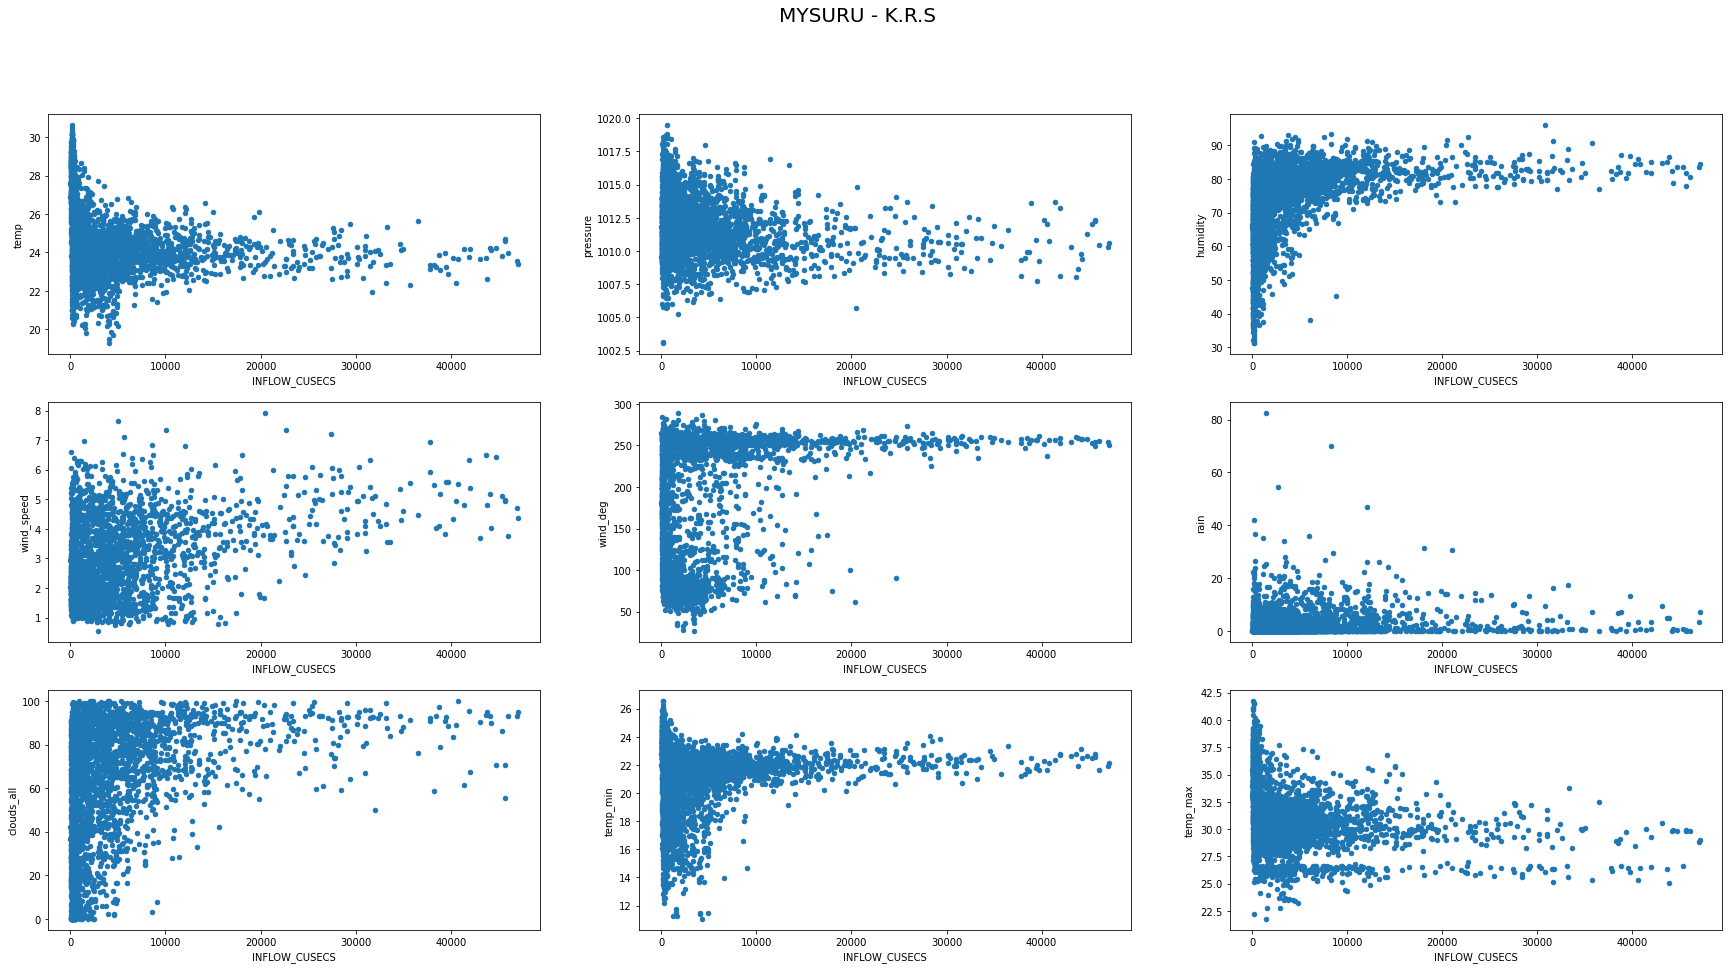

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(30, 15))
m.plot(x='INFLOW_CUSECS', y='temp', kind='scatter', ax=ax[0][0], subplots=True)
m.plot(x='INFLOW_CUSECS', y='pressure', kind='scatter', ax=ax[0][1], subplots=True)
m.plot(x='INFLOW_CUSECS', y='humidity', kind='scatter', ax=ax[0][2], subplots=True)
m.plot(x='INFLOW_CUSECS', y='wind_speed', kind='scatter', ax=ax[1][0], subplots=True)
m.plot(x='INFLOW_CUSECS', y='wind_deg', kind='scatter', ax=ax[1][1], subplots=True)
m.plot(x='INFLOW_CUSECS', y='rain', kind='scatter', ax=ax[1][2], subplots=True)
m.plot(x='INFLOW_CUSECS', y='clouds_all', kind='scatter', ax=ax[2][0], subplots=True)
m.plot(x='INFLOW_CUSECS', y='temp_min', kind='scatter', ax=ax[2][1], subplots=True)
m.plot(x='INFLOW_CUSECS', y='temp_max', kind='scatter', ax=ax[2][2], subplots=True)
fig.suptitle('MYSURU - K.R.S', fontsize=20)
plt.show()

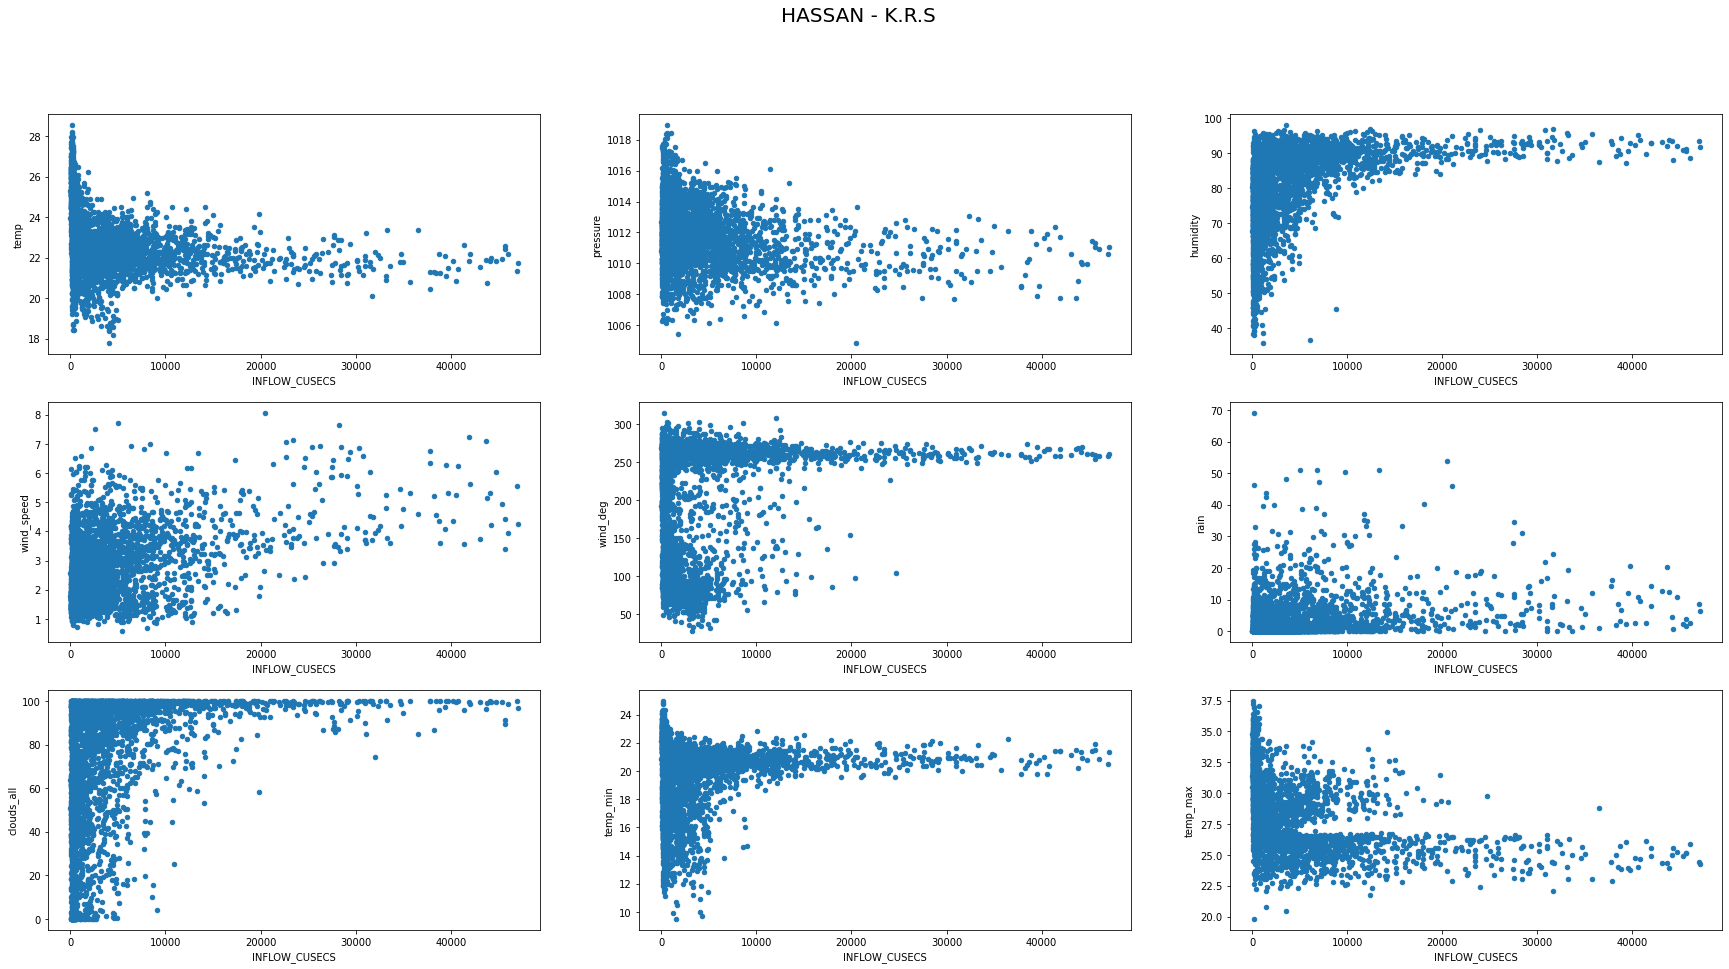

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(30, 15))
h.plot(x='INFLOW_CUSECS', y='temp', kind='scatter', ax=ax[0][0], subplots=True)
h.plot(x='INFLOW_CUSECS', y='pressure', kind='scatter', ax=ax[0][1], subplots=True)
h.plot(x='INFLOW_CUSECS', y='humidity', kind='scatter', ax=ax[0][2], subplots=True)
h.plot(x='INFLOW_CUSECS', y='wind_speed', kind='scatter', ax=ax[1][0], subplots=True)
h.plot(x='INFLOW_CUSECS', y='wind_deg', kind='scatter', ax=ax[1][1], subplots=True)
h.plot(x='INFLOW_CUSECS', y='rain', kind='scatter', ax=ax[1][2], subplots=True)
h.plot(x='INFLOW_CUSECS', y='clouds_all', kind='scatter', ax=ax[2][0], subplots=True)
h.plot(x='INFLOW_CUSECS', y='temp_min', kind='scatter', ax=ax[2][1], subplots=True)
h.plot(x='INFLOW_CUSECS', y='temp_max', kind='scatter', ax=ax[2][2], subplots=True)
fig.suptitle('HASSAN - K.R.S', fontsize=20)
plt.show()

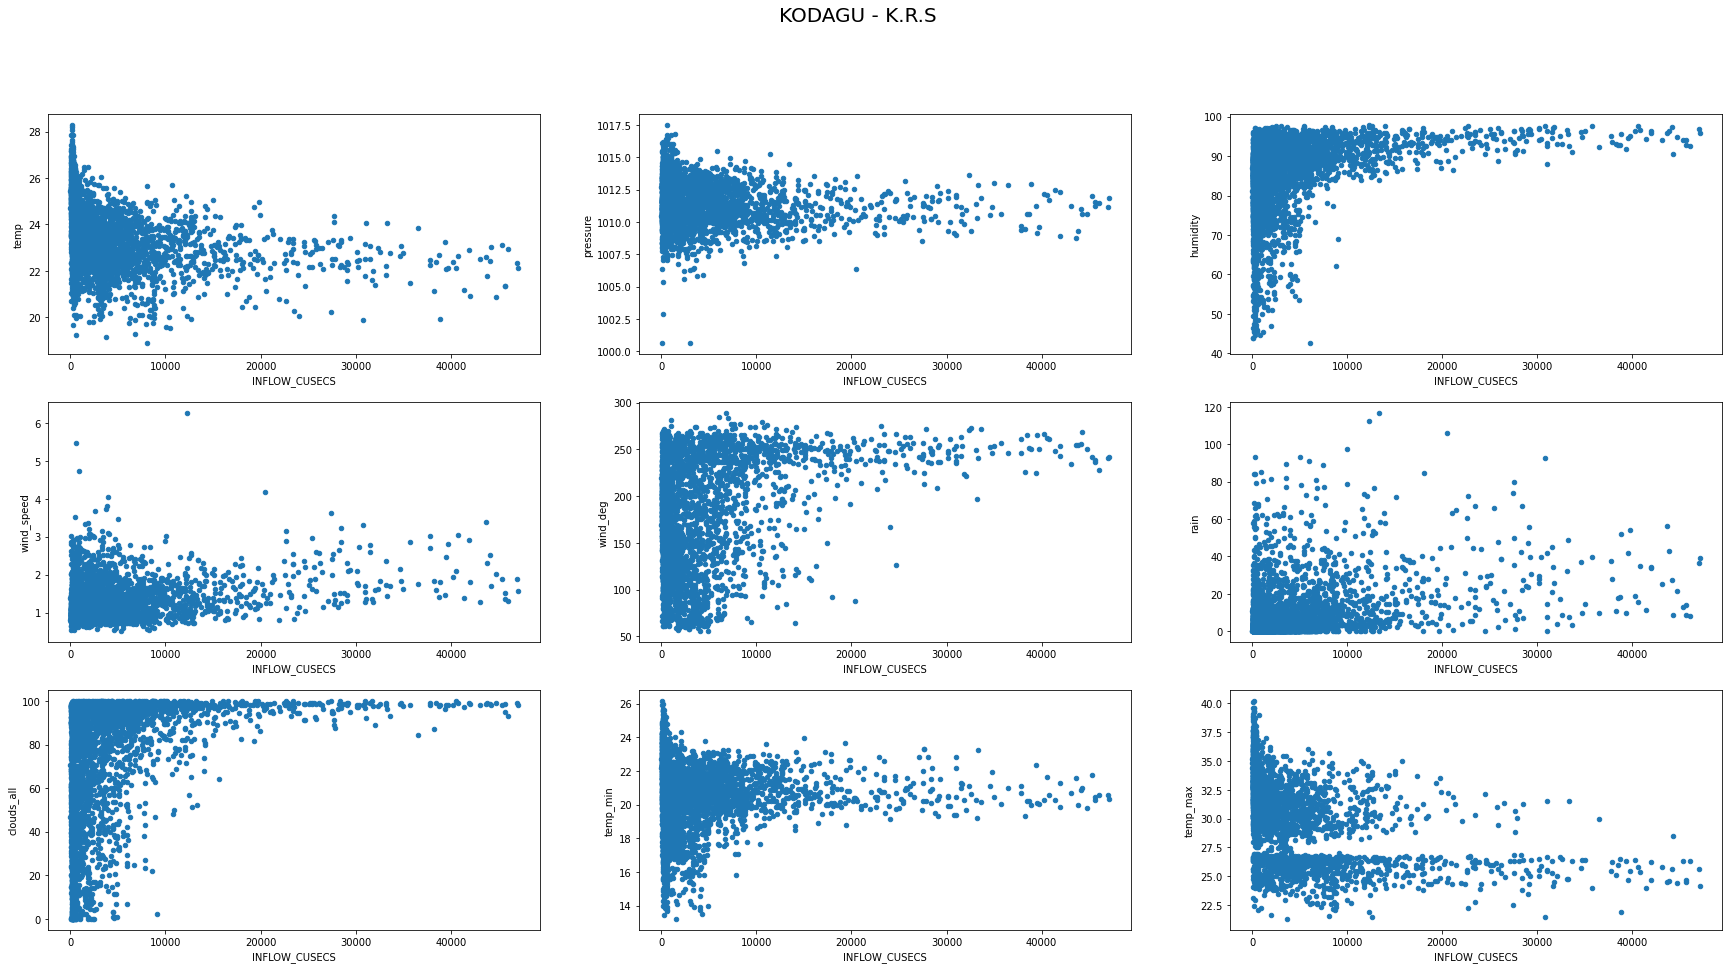

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(30, 15))
k.plot(x='INFLOW_CUSECS', y='temp', kind='scatter', ax=ax[0][0], subplots=True)
k.plot(x='INFLOW_CUSECS', y='pressure', kind='scatter', ax=ax[0][1], subplots=True)
k.plot(x='INFLOW_CUSECS', y='humidity', kind='scatter', ax=ax[0][2], subplots=True)
k.plot(x='INFLOW_CUSECS', y='wind_speed', kind='scatter', ax=ax[1][0], subplots=True)
k.plot(x='INFLOW_CUSECS', y='wind_deg', kind='scatter', ax=ax[1][1], subplots=True)
k.plot(x='INFLOW_CUSECS', y='rain', kind='scatter', ax=ax[1][2], subplots=True)
k.plot(x='INFLOW_CUSECS', y='clouds_all', kind='scatter', ax=ax[2][0], subplots=True)
k.plot(x='INFLOW_CUSECS', y='temp_min', kind='scatter', ax=ax[2][1], subplots=True)
k.plot(x='INFLOW_CUSECS', y='temp_max', kind='scatter', ax=ax[2][2], subplots=True)
fig.suptitle('KODAGU - K.R.S', fontsize=20)
plt.show()

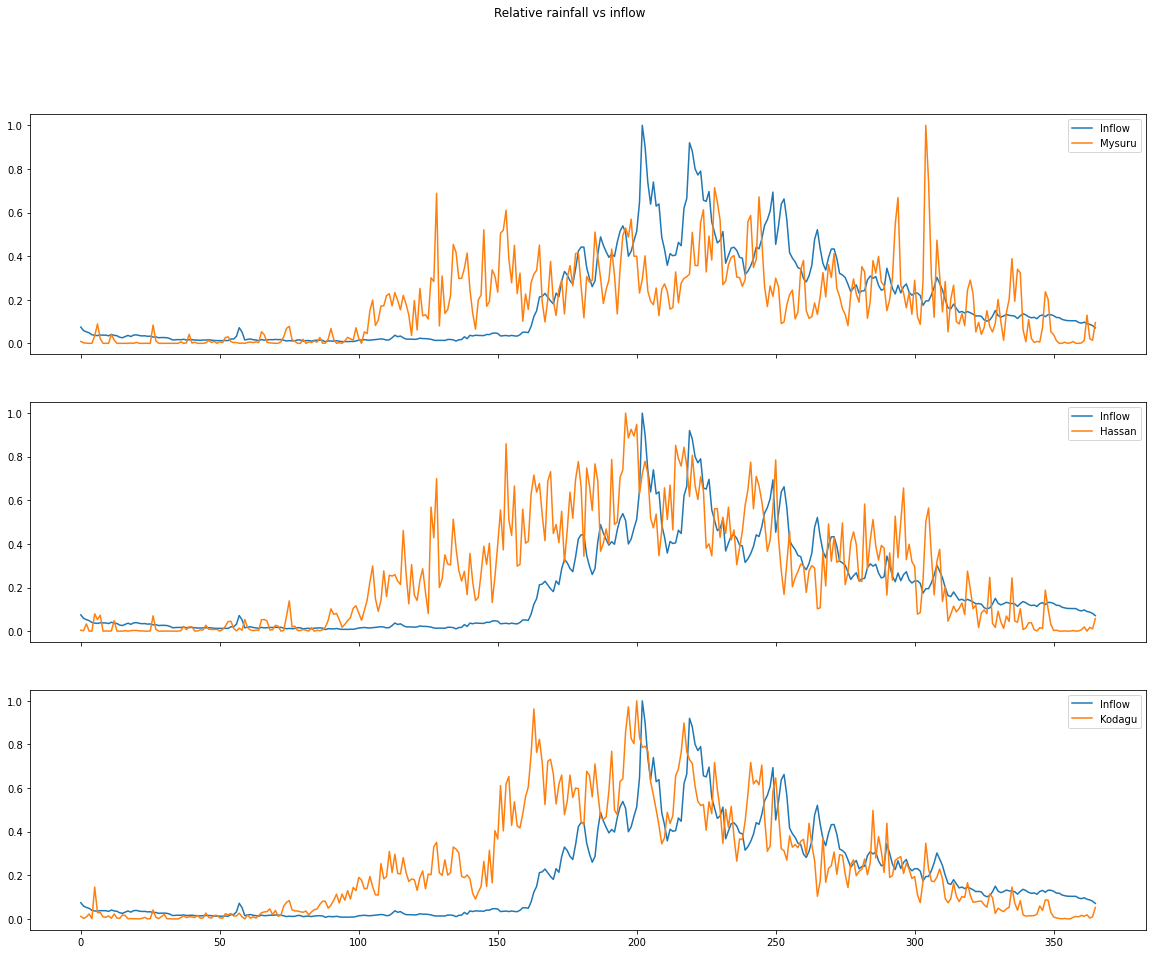

In [ ]:
m.rename(columns={'rain': 'mysuru_rain'}, inplace=True)
h.rename(columns={'rain': 'hassan_rain'}, inplace=True)
k.rename(columns={'rain': 'kodagu_rain'}, inplace=True)
t = m[['YYYY', 'DD', 'MM', 'INFLOW_CUSECS', 'mysuru_rain']].merge(h[['YYYY', 'DD', 'MM', 'INFLOW_CUSECS', 'hassan_rain']], on=['YYYY', 'DD', 'MM', 'INFLOW_CUSECS'], how='inner').merge(k[['YYYY', 'DD', 'MM', 'INFLOW_CUSECS', 'kodagu_rain']], on=['YYYY', 'DD', 'MM', 'INFLOW_CUSECS'], how='inner')
g = t.groupby(['MM', 'DD'])[['INFLOW_CUSECS', 'mysuru_rain', 'hassan_rain', 'kodagu_rain']].mean()

fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(20, 15))
ax[0].plot(range(g.shape[0]), g['INFLOW_CUSECS'].values / g['INFLOW_CUSECS'].max(), label='Inflow')
ax[0].plot(range(g.shape[0]), g['mysuru_rain'].values / g['mysuru_rain'].max(), label='Mysuru')
ax[1].plot(range(g.shape[0]), g['INFLOW_CUSECS'].values / g['INFLOW_CUSECS'].max(), label='Inflow')
ax[1].plot(range(g.shape[0]), g['hassan_rain'].values / g['hassan_rain'].max(), label='Hassan')
ax[2].plot(range(g.shape[0]), g['INFLOW_CUSECS'].values / g['INFLOW_CUSECS'].max(), label='Inflow')
ax[2].plot(range(g.shape[0]), g['kodagu_rain'].values / g['kodagu_rain'].max(), label='Kodagu')
ax[0].legend()
ax[1].legend()
ax[2].legend()
fig.suptitle('Relative rainfall vs inflow')
plt.show()

### Dataset Transformation

In [ ]:
inflow_df = inflow_df[['INFLOW_CUSECS', 'YEAR', 'MONTH', 'DATE', 'SEASON']]
inflow_df.head()

,INFLOW_CUSECS,YEAR,MONTH,DATE,SEASON
0,2029.0,2011,1,1,WINTER
1,3084.0,2011,1,2,WINTER
2,2776.0,2011,1,3,WINTER
3,2311.0,2011,1,4,WINTER
4,1847.0,2011,1,5,WINTER


In [ ]:
month_le = LabelEncoder().fit(inflow_df['MONTH'].unique())
date_le = LabelEncoder().fit(inflow_df['DATE'].unique())
season_le = LabelEncoder().fit(inflow_df['SEASON'].unique())

In [ ]:
# month_oe = OneHotEncoder().fit(inflow_df[['MONTH']])
# date_oe = OneHotEncoder().fit(inflow_df[['DATE']])
# season_oe = OneHotEncoder().fit(inflow_df[['SEASON']])

In [ ]:
rs_inflow = RobustScaler().fit(inflow_df[['INFLOW_CUSECS']])
rs_temp = RobustScaler().fit(weather_df[['temp']])
rs_feels_like = RobustScaler().fit(weather_df[['feels_like']])
rs_temp_min = RobustScaler().fit(weather_df[['temp_min']])
rs_temp_max = RobustScaler().fit(weather_df[['temp_max']])
rs_pressure = RobustScaler().fit(weather_df[['pressure']])
rs_humidity = RobustScaler().fit(weather_df[['humidity']])
rs_wind_speed = RobustScaler().fit(weather_df[['wind_speed']])
rs_wind_deg = RobustScaler().fit(weather_df[['wind_deg']])
rs_rain = RobustScaler().fit(weather_df[['rain']])
rs_clouds_all = RobustScaler().fit(weather_df[['clouds_all']])
# remaining columns will be divided by 24 for scaling purpose.

In [ ]:
inflow_df['INFLOW_CUSECS'] = rs_inflow.transform(inflow_df[['INFLOW_CUSECS']]).flatten()
inflow_df.head()

,INFLOW_CUSECS,YEAR,MONTH,DATE,SEASON
0,0.073551,2011,1,1,WINTER
1,0.289397,2011,1,2,WINTER
2,0.226382,2011,1,3,WINTER
3,0.131246,2011,1,4,WINTER
4,0.036315,2011,1,5,WINTER


In [ ]:
weather_df.columns

Index(['date', 'city_name', 'temp', 'feels_like', 'temp_min', 'temp_max',
       'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain', 'clouds_all',
       'broken clouds', 'overcast clouds', 'scattered clouds', 'sky is clear',
       'few clouds', 'fog', 'light rain', 'mist', 'haze', 'moderate rain',
       'heavy intensity rain', 'light intensity drizzle', 'drizzle',
       'heavy intensity drizzle', 'very heavy rain',
       'thunderstorm with heavy rain', 'thunderstorm with rain',
       'thunderstorm', 'proximity shower rain', 'thunderstorm with light rain',
       'shower rain', 'light intensity shower rain', 'light thunderstorm',
       'YYYY', 'MM', 'DD'],
      dtype='object')

In [ ]:
weather_df['temp'] = rs_temp.transform(weather_df[['temp']]).flatten()
weather_df['feels_like'] = rs_feels_like.transform(weather_df[['feels_like']]).flatten()
weather_df['temp_min'] = rs_temp_min.transform(weather_df[['temp_min']]).flatten()
weather_df['temp_max'] = rs_temp_max.transform(weather_df[['temp_max']]).flatten()
weather_df['pressure'] = rs_pressure.transform(weather_df[['pressure']]).flatten()
weather_df['humidity'] = rs_humidity.transform(weather_df[['humidity']]).flatten()
weather_df['wind_speed'] = rs_wind_speed.transform(weather_df[['wind_speed']]).flatten()
weather_df['wind_deg'] = rs_wind_deg.transform(weather_df[['wind_deg']]).flatten()
weather_df['rain'] = rs_rain.transform(weather_df[['rain']]).flatten()
weather_df['clouds_all'] = rs_clouds_all.transform(weather_df[['clouds_all']]).flatten()
weather_df.loc[:, ('broken clouds', 'overcast clouds', 'scattered clouds', 'sky is clear',
       'few clouds', 'fog', 'light rain', 'mist', 'haze', 'moderate rain',
       'heavy intensity rain', 'light intensity drizzle', 'drizzle',
       'heavy intensity drizzle', 'very heavy rain',
       'thunderstorm with heavy rain', 'thunderstorm with rain',
       'thunderstorm', 'proximity shower rain', 'thunderstorm with light rain',
       'shower rain', 'light intensity shower rain', 'light thunderstorm')] = weather_df.loc[:, ('broken clouds', 'overcast clouds', 'scattered clouds', 'sky is clear',
       'few clouds', 'fog', 'light rain', 'mist', 'haze', 'moderate rain',
       'heavy intensity rain', 'light intensity drizzle', 'drizzle',
       'heavy intensity drizzle', 'very heavy rain',
       'thunderstorm with heavy rain', 'thunderstorm with rain',
       'thunderstorm', 'proximity shower rain', 'thunderstorm with light rain',
       'shower rain', 'light intensity shower rain', 'light thunderstorm')] / 24

In [ ]:
weather_df.head()

,date,city_name,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain,clouds_all,broken clouds,overcast clouds,scattered clouds,sky is clear,few clouds,fog,light rain,mist,haze,moderate rain,heavy intensity rain,light intensity drizzle,drizzle,heavy intensity drizzle,very heavy rain,thunderstorm with heavy rain,thunderstorm with rain,thunderstorm,proximity shower rain,thunderstorm with light rain,shower rain,light intensity shower rain,light thunderstorm,YYYY,MM,DD
0,2010-01-01,Hassan,-0.736,-0.737201,-1.281690,-0.657143,0.683274,-0.156784,0.559748,-0.826564,-0.116022,-0.149059,0.208333,0.500000,0.166667,0.125000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010,1,1
1,2010-01-01,Kodagu,0.116,0.180887,-0.281690,0.242857,0.209964,0.161345,-0.232704,-0.714651,0.057090,-0.473641,0.125000,0.166667,0.333333,0.000000,0.250000,0.083333,0.041667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010,1,1
2,2010-01-01,Mysuru,0.228,0.112628,-0.718310,0.048214,0.476868,-0.698404,0.440252,-0.818667,-0.116022,-0.894149,0.208333,0.000000,0.333333,0.166667,0.291667,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010,1,1
3,2010-01-02,Hassan,-1.152,-1.153584,-2.250000,-0.478571,1.306050,-0.394527,0.314465,-0.969765,-0.116022,-1.303287,0.083333,0.000000,0.125000,0.791667,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010,1,2
4,2010-01-02,Kodagu,-0.020,0.078498,-0.591549,0.330357,0.889680,-0.130559,-0.320755,-0.652602,-0.116022,-1.076700,0.125000,0.000000,0.125000,0.541667,0.125000,0.000000,0.000000,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010,1,2


In [ ]:
kodagu_df = weather_df[weather_df['city_name'] == 'Kodagu'].reset_index(drop=True)
hassan_df = weather_df[weather_df['city_name'] == 'Hassan'].reset_index(drop=True)
mysuru_df = weather_df[weather_df['city_name'] == 'Mysuru'].reset_index(drop=True)

In [ ]:
train_inflow_df = inflow_df[inflow_df['YEAR'] < 2020].reset_index(drop=True)
val_inflow_df = inflow_df[inflow_df['YEAR'] == 2020].reset_index(drop=True)

train_inflow_df.shape, val_inflow_df.shape

((2944, 5), (330, 5))

In [ ]:
def embed_day(df):
    data = {}
    for index in tqdm(df.index):
        row = df.iloc[index]
        inflow = row['INFLOW_CUSECS']
        year = row['YEAR']
        month = row['MONTH']
        date = row['DATE']
        season = row['SEASON']

        ddmmyyyy = datetime.date(year, month, date)
        ddmmyyyy_list = [str(ddmmyyyy + timedelta(days=day)) for day in range(2)]

        sel_kodagu = kodagu_df[kodagu_df['date'].isin(ddmmyyyy_list)].drop(columns=['date', 'city_name', 'YYYY', 'MM', 'DD']).values.flatten()
        sel_hassan = hassan_df[hassan_df['date'].isin(ddmmyyyy_list)].drop(columns=['date', 'city_name', 'YYYY', 'MM', 'DD']).values.flatten()
        sel_mysuru = mysuru_df[mysuru_df['date'].isin(ddmmyyyy_list)].drop(columns=['date', 'city_name', 'YYYY', 'MM', 'DD']).values.flatten()
        
        month_transformed = month_le.transform([month])
        date_transformed = date_le.transform([date])
        season_transformed = season_le.transform([season])
        # month_transformed = month_oe.transform([[month]]).toarray().flatten()
        # date_transformed = date_oe.transform([[date]]).toarray().flatten()
        # season_transformed = season_oe.transform([[season]]).toarray().flatten()
        
        data[ddmmyyyy] = np.concatenate([month_transformed, date_transformed, season_transformed, sel_kodagu, sel_hassan, [inflow]])
        # data[ddmmyyyy] = np.concatenate([month_transformed, date_transformed, season_transformed, sel_mysuru, sel_kodagu, sel_hassan, [inflow]])
    return pd.DataFrame(data).T

In [ ]:
train_emb_df = embed_day(train_inflow_df)
val_emb_df = embed_day(val_inflow_df)

  0%|          | 0/2944 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

In [ ]:
train_emb_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135
2011-01-01,0.0,0.0,2.0,-0.276,-0.218430,-0.750000,0.078571,-0.604982,0.085519,-0.540881,-0.152452,-0.092081,-0.718421,0.375000,0.000000,0.250000,0.041667,0.208333,0.0,0.041667,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.504,-0.402730,-1.302817,0.042857,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.980,-0.931741,-1.105634,-0.423214,-0.295374,-0.059863,-0.547170,-0.269329,-0.116022,-0.174695,0.416667,0.333333,0.208333,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.073551
2011-01-02,0.0,1.0,2.0,-0.504,-0.402730,-1.302817,0.042857,-0.398577,0.116306,-0.408805,-0.163132,-0.116022,-0.340087,0.458333,0.166667,0.250000,0.000000,0.041667,0.0,0.000000,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.436,-0.378840,-0.573944,-0.139286,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.836,-0.846416,-0.933099,-0.801786,0.060498,-0.292474,0.371069,-0.676143,-0.116022,0.139549,0.458333,0.500000,0.041667,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.289397
2011-01-03,0.0,2.0,2.0,-0.436,-0.378840,-0.573944,-0.139286,-0.192171,0.057013,-0.471698,-0.287530,-0.088398,0.044036,0.291667,0.458333,0.083333,0.000000,0.041667,0.0,0.041667,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076,-0.027304,-0.721831,0.171429,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.968,-0.996587,-1.281690,-0.635714,0.120996,-0.444128,0.484277,-0.764516,-0.116022,0.214596,0.458333,0.541667,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.226382
2011-01-04,0.0,3.0,2.0,0.076,-0.027304,-0.721831,0.171429,-0.309609,-0.503991,-0.257862,-0.502783,-0.057090,0.038867,0.125000,0.583333,0.125000,0.000000,0.000000,0.0,0.083333,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.232,0.177474,-0.475352,0.375000,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.092,-1.068259,-1.380282,-0.860714,0.000000,-0.180730,0.402516,-0.927422,-0.116022,0.472194,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.131246
2011-01-05,0.0,4.0,2.0,0.232,0.177474,-0.475352,0.375000,-0.533808,-0.537058,-0.257862,-0.602512,-0.116022,0.317139,0.000000,0.875000,0.041667,0.000000,0.000000,0.0,0.000000,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.096,0.044369,-0.584507,0.182143,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.120,-1.163823,-1.883803,-0.721429,0.000000,-0.629989,0.327044,-1.022413,-0.116022,0.146578,0.291667,0.541667,0.166667,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.036315


In [ ]:
X_train, y_train = train_emb_df.values[:, :-1], train_emb_df.values[:, -1]
X_val, y_val = val_emb_df.values[:, :-1], val_emb_df.values[:, -1]
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((2944, 135), (2944,), (330, 135), (330,))

### Model Training

In [29]:
%%time
model = StructuredDataRegressor(max_trials=20, seed=10, project_name='krs_inflow_autokeras')
model.fit(x=X_train, y=y_train)

92/92 [==============================] - 2s 4ms/step - loss: 2.3366 - mean_squared_error: 2.3366
INFO:tensorflow:Assets written to: ./krs_inflow_autokeras/best_model/assets
CPU times: user 35min 39s, sys: 1min 13s, total: 36min 52s
Wall time: 34min 20s


In [32]:
model.export_model().summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 135)]             0         
_________________________________________________________________
multi_category_encoding (Mul (None, 135)               0         
_________________________________________________________________
normalization (Normalization (None, 135)               271       
_________________________________________________________________
dense (Dense)                (None, 32)                4352      
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)                0     

In [36]:
mse, _ = model.evaluate(X_train, y_train, verbose=0)
print('Train MSE: %.3f' % mse)
mse, _ = model.evaluate(X_val, y_val, verbose=0)
print('Test MSE: %.3f' % mse)

Train MSE: 2.237
Test MSE: 1.079


### Predict and check Loss

In [37]:
y_pred_train = model.predict(X_train)
y_pred_train = rs_inflow.inverse_transform(y_pred_train.reshape(-1, 1)).flatten()
y_train_inv_trf = rs_inflow.inverse_transform(y_train.reshape(-1, 1)).flatten()
loss = mean_squared_error(y_train_inv_trf, y_pred_train)
loss

92/92 [==============================] - 0s 4ms/step


53436866.259471

In [38]:
y_pred_test = model.predict(X_val)
y_pred_test = rs_inflow.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()
y_val_inv_trf = rs_inflow.inverse_transform(y_val.reshape(-1, 1)).flatten()
loss = mean_squared_error(y_val_inv_trf, y_pred_test)
loss

11/11 [==============================] - 0s 4ms/step


25769493.706069797

### Compare Prediction on Test data

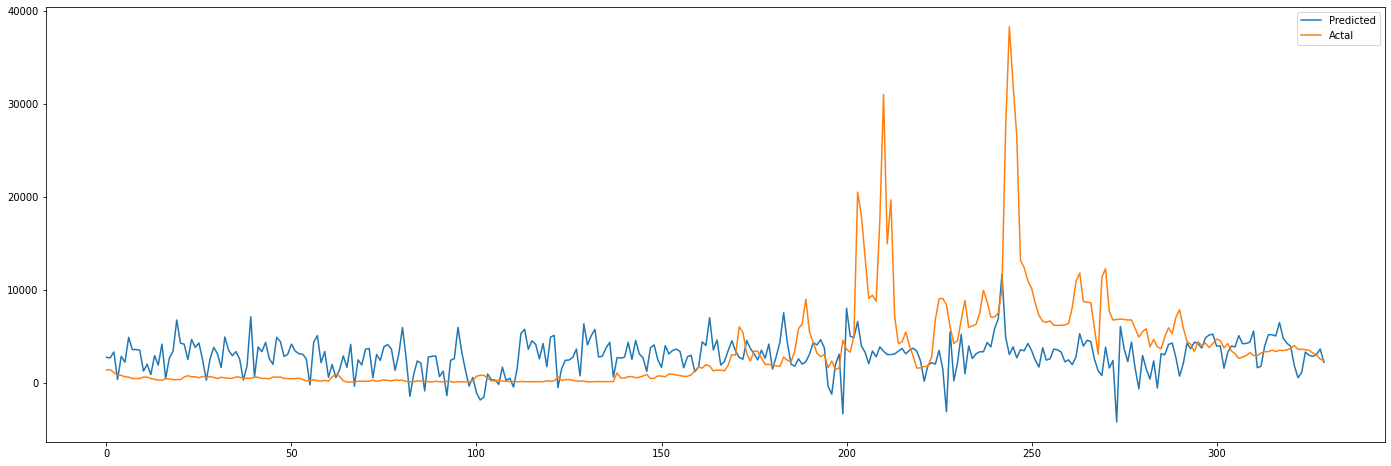

In [39]:
plt.figure(figsize=(24,8))
plt.plot(y_pred_test, label='Predicted')
plt.plot(y_val_inv_trf, label='Actal')
plt.legend()
plt.show()

### Compare Prediction on Entire data

In [40]:
y_pred = np.concatenate([y_pred_train, y_pred_test])
y_true = np.concatenate([y_train, y_val])
model_pred_df = pd.DataFrame({'y_pred': y_pred, 'y_true': y_true})
model_pred_df

,y_pred,y_true
0,-1314.383057,0.073551
1,390.677612,0.289397
2,2112.568115,0.226382
3,3753.076904,0.131246
4,3439.278320,0.036315
...,...,...
3269,2952.311035,0.373689
3270,2842.068848,0.312516
3271,3036.380127,0.277531
3272,3617.087891,0.176052


In [41]:
inflow_df['Predicted_Inflow'] = y_pred
inflow_df

,INFLOW_CUSECS,YEAR,MONTH,DATE,SEASON,Predicted_Inflow
0,0.073551,2011,1,1,WINTER,-1314.383057
1,0.289397,2011,1,2,WINTER,390.677612
2,0.226382,2011,1,3,WINTER,2112.568115
3,0.131246,2011,1,4,WINTER,3753.076904
4,0.036315,2011,1,5,WINTER,3439.278320
...,...,...,...,...,...,...
3269,0.373689,2020,12,12,WINTER,2952.311035
3270,0.312516,2020,12,13,WINTER,2842.068848
3271,0.277531,2020,12,14,WINTER,3036.380127
3272,0.176052,2020,12,15,WINTER,3617.087891


In [42]:
inflow_df['INFLOW_CUSECS'] = rs_inflow.inverse_transform(inflow_df[['INFLOW_CUSECS']])
inflow_df.head()

,INFLOW_CUSECS,YEAR,MONTH,DATE,SEASON,Predicted_Inflow
0,2029.0,2011,1,1,WINTER,-1314.383057
1,3084.0,2011,1,2,WINTER,390.677612
2,2776.0,2011,1,3,WINTER,2112.568115
3,2311.0,2011,1,4,WINTER,3753.076904
4,1847.0,2011,1,5,WINTER,3439.278320


In [43]:
avg_daily_pred_inflow = inflow_df.groupby(['MONTH', 'DATE'])['Predicted_Inflow'].mean().values
avg_daily_actual_inflow = inflow_df.groupby(['MONTH', 'DATE'])['INFLOW_CUSECS'].mean().values

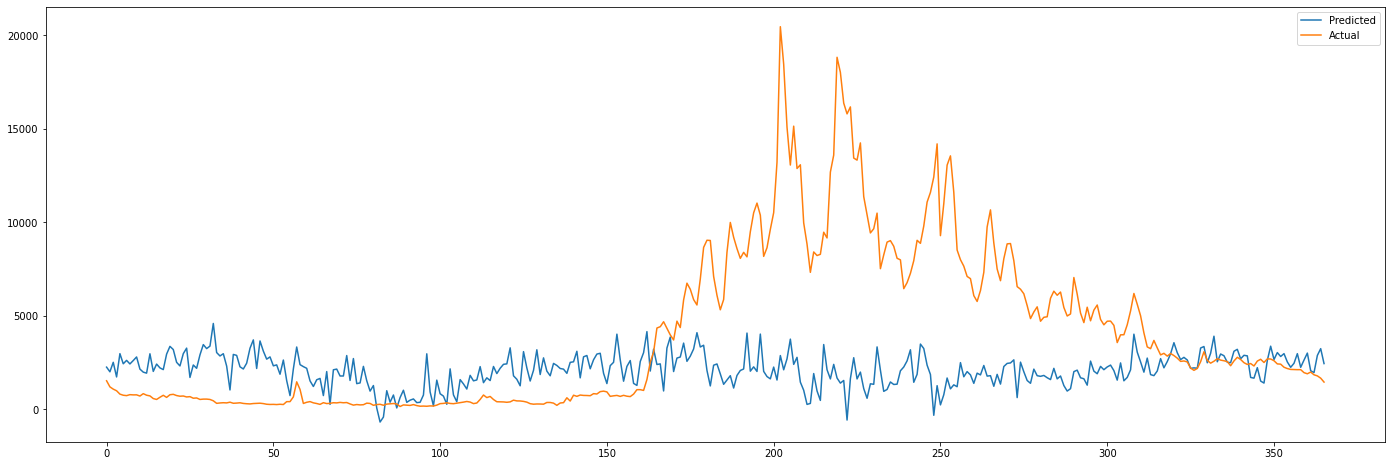

In [44]:
plt.figure(figsize=(24, 8))
plt.plot(avg_daily_pred_inflow, label='Predicted')
plt.plot(avg_daily_actual_inflow, label='Actual')
plt.legend()
# ax2.plot(avg_daily_actual_rainfall, label='Actual')
plt.show()

In [45]:
inflow_df.sort_values(by=['YEAR', 'MONTH', 'DATE'], inplace=True)

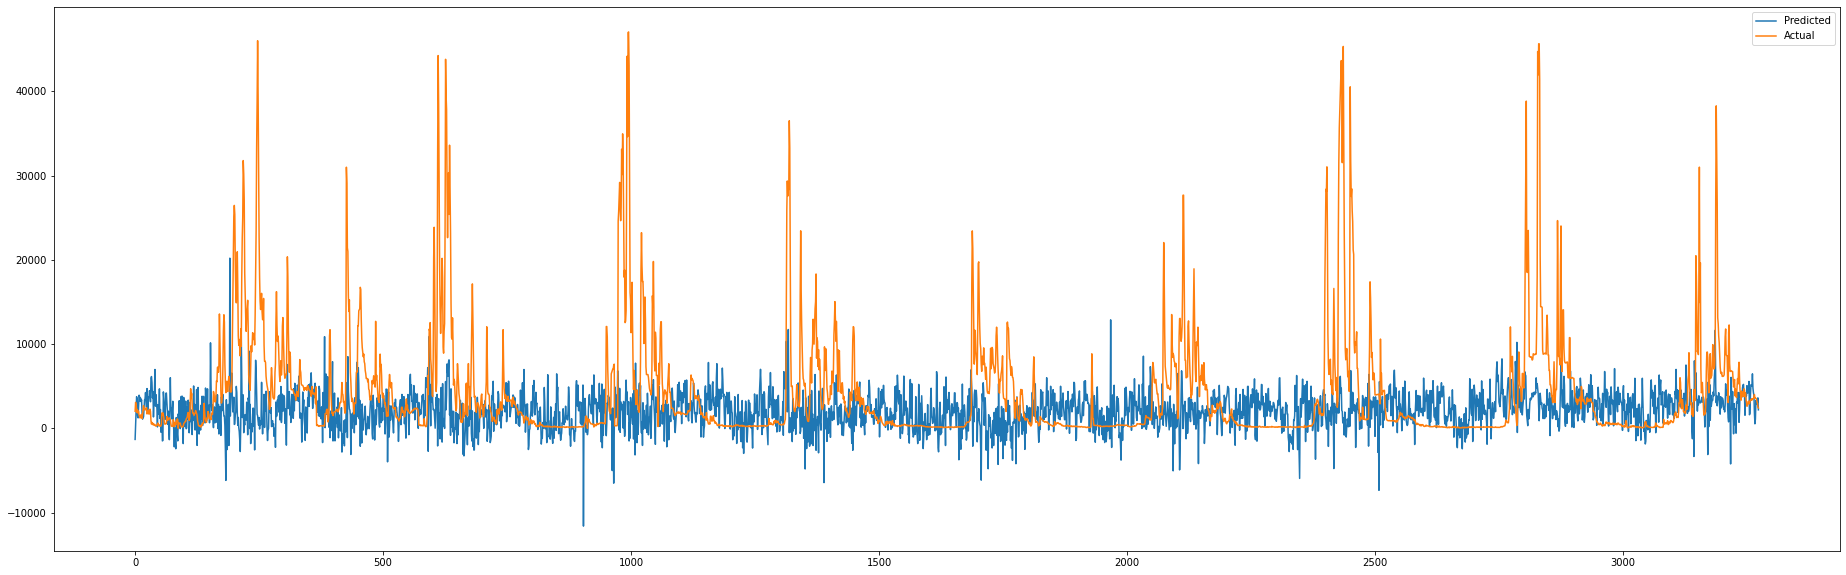

In [46]:
plt.figure(figsize=(32, 10))
plt.plot(inflow_df['Predicted_Inflow'], label='Predicted')
plt.plot(inflow_df['INFLOW_CUSECS'], label='Actual')
plt.legend()
plt.show()

In [47]:
((y_train_inv_trf - y_pred_train) ** 2).mean() ** .5

7310.0524115406315

In [48]:
((y_val_inv_trf - y_pred_test) ** 2).mean() ** .5

5076.366191092778

In [49]:
feature_list = [['Month', 'Date', 'Season']] + [[f'{day_region}_temp', f'{day_region}_feels_like', f'{day_region}_temp_min', f'{day_region}_temp_max', f'{day_region}_pressure', f'{day_region}_humidity',
                                                 f'{day_region}_wind_speed', f'{day_region}_wind_deg', f'{day_region}_rain', f'{day_region}_clouds_all', f'{day_region}_broken clouds', f'{day_region}_overcast clouds',
                                                 f'{day_region}_scattered clouds', f'{day_region}_sky is clear', f'{day_region}_few clouds', f'{day_region}_fog', f'{day_region}_light rain', f'{day_region}_mist',
                                                 f'{day_region}_haze', f'{day_region}_moderate rain', f'{day_region}_heavy intensity rain', f'{day_region}_light intensity drizzle', f'{day_region}_drizzle',
                                                 f'{day_region}_heavy intensity drizzle', f'{day_region}_very heavy rain', f'{day_region}_thunderstorm with heavy rain', f'{day_region}_thunderstorm with rain',
                                                 f'{day_region}_thunderstorm', f'{day_region}_proximity shower rain', f'{day_region}_thunderstorm with light rain', f'{day_region}_shower rain',
                                                 f'{day_region}_light intensity shower rain', f'{day_region}_light thunderstorm'] for day_region in ['1_mysuru', '2_mysuru', '1_kodagu', '2_kodagu', '1_hassan', '2_hassan']]
feature_list = feature_list[0] + feature_list[1] + feature_list[2] + feature_list[3] + feature_list[4] + feature_list[5] + feature_list[6]
len(feature_list)

201

In [50]:
feature_list

['Month',
 'Date',
 'Season',
 '1_mysuru_temp',
 '1_mysuru_feels_like',
 '1_mysuru_temp_min',
 '1_mysuru_temp_max',
 '1_mysuru_pressure',
 '1_mysuru_humidity',
 '1_mysuru_wind_speed',
 '1_mysuru_wind_deg',
 '1_mysuru_rain',
 '1_mysuru_clouds_all',
 '1_mysuru_broken clouds',
 '1_mysuru_overcast clouds',
 '1_mysuru_scattered clouds',
 '1_mysuru_sky is clear',
 '1_mysuru_few clouds',
 '1_mysuru_fog',
 '1_mysuru_light rain',
 '1_mysuru_mist',
 '1_mysuru_haze',
 '1_mysuru_moderate rain',
 '1_mysuru_heavy intensity rain',
 '1_mysuru_light intensity drizzle',
 '1_mysuru_drizzle',
 '1_mysuru_heavy intensity drizzle',
 '1_mysuru_very heavy rain',
 '1_mysuru_thunderstorm with heavy rain',
 '1_mysuru_thunderstorm with rain',
 '1_mysuru_thunderstorm',
 '1_mysuru_proximity shower rain',
 '1_mysuru_thunderstorm with light rain',
 '1_mysuru_shower rain',
 '1_mysuru_light intensity shower rain',
 '1_mysuru_light thunderstorm',
 '2_mysuru_temp',
 '2_mysuru_feels_like',
 '2_mysuru_temp_min',
 '2_mysuru_

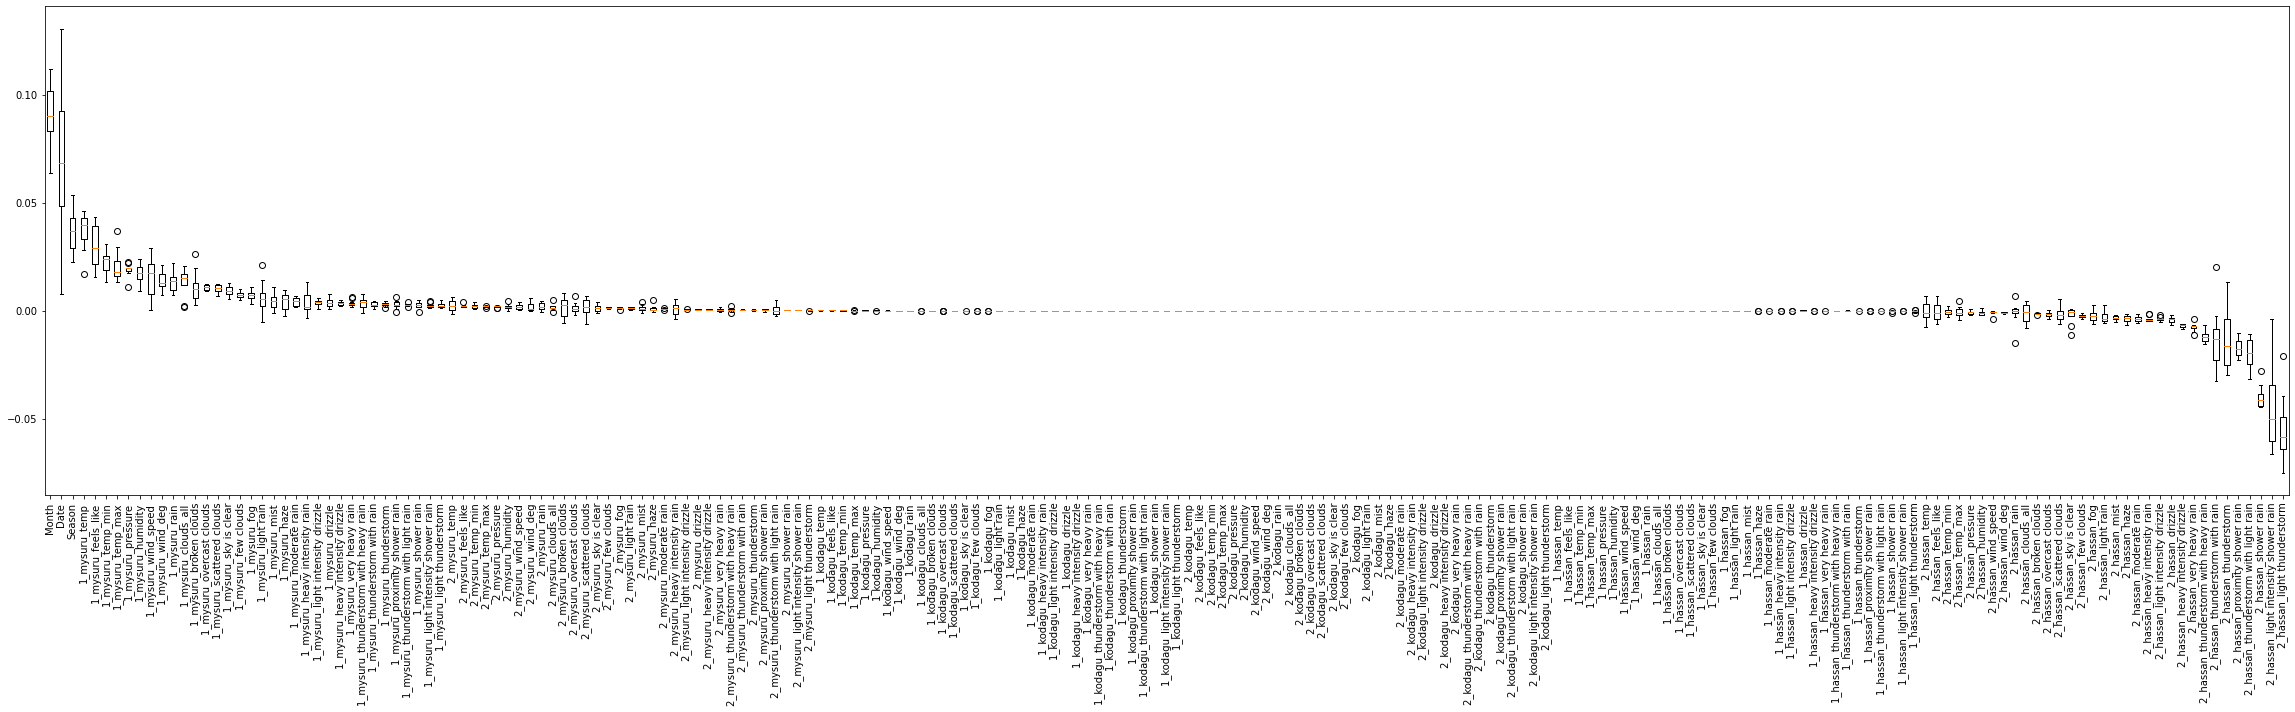

1_mysuru_humidity: -0.055 +/- 0.015
2_mysuru_humidity: -0.044 +/- 0.020
2_hassan_wind_speed: -0.040 +/- 0.005
1_hassan_wind_speed: -0.020 +/- 0.007
1_kodagu_humidity: -0.017 +/- 0.004
1_mysuru_temp_max: -0.013 +/- 0.014
1_hassan_humidity: -0.013 +/- 0.014
1_kodagu_clouds_all: -0.012 +/- 0.003
1_kodagu_temp_max: -0.008 +/- 0.002
2_kodagu_clouds_all: -0.007 +/- 0.001
2_mysuru_wind_speed: -0.004 +/- 0.001
1_kodagu_moderate rain: -0.004 +/- 0.001
2_kodagu_heavy intensity rain: -0.004 +/- 0.001
1_hassan_temp_max: -0.004 +/- 0.001
1_hassan_light rain: -0.004 +/- 0.002
2_mysuru_broken clouds: -0.003 +/- 0.001
1_kodagu_wind_speed: -0.003 +/- 0.002
1_mysuru_temp: -0.002 +/- 0.003
1_mysuru_broken clouds: -0.002 +/- 0.001
1_mysuru_temp_min: -0.002 +/- 0.004
1_kodagu_wind_deg: -0.002 +/- 0.003
2_hassan_overcast clouds: -0.002 +/- 0.001
2_mysuru_moderate rain: -0.001 +/- 0.000
1_kodagu_overcast clouds: -0.001 +/- 0.004
1_mysuru_thunderstorm: -0.001 +/- 0.005
2_hassan_moderate rain: -0.001 +/- 0.000

In [ ]:
r = permutation_importance(automl, X_val, y_val,
                           n_repeats=10,
                           random_state=0)

sort_idx = r.importances_mean.argsort()[::-1]
plt.figure(figsize=(32, 10))
plt.boxplot(r.importances[sort_idx].T, labels=feature_list)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

for i in sort_idx[::-1]:
    print(f"{feature_list[i]:10s}: {r.importances_mean[i]:.3f} +/- "
          f"{r.importances_std[i]:.3f}")

In [ ]:
sort_idx.shape

(201,)

In [ ]:
len(feature_list)

36